In [4]:
# %pip install tensorflow

# **Visualise images generated from Data Augmentation** 


In [ ]:
# Visualize N images with data augmentation applied,
# where N = n_images_shown can be chosen by the user.

import os
import glob
from numpy import expand_dims
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

n_images_shown = 4             # This parameter can be modified by the user

for class_tag in classes:
  input_path = 'G:\My Drive\Datasets\ ' + dataset_name + '/' + class_tag + '/'
  output_path = 'G:\My Drive\Datasets\ ' + dataset_name + '/' + new_dataset + '/' + class_tag + '/'

  counter = 0
  for filename in os.listdir(input_path):
    if filename.endswith(".jpg"):

      if counter > n_images_shown:
        break

      # Show the obtained AUGMENTATED IMAGES (plus ORIGINAL IMAGE) for the specific orginal image
      print(filename)
      transformation_array_size = len(transformation_array)
      # Define subplot
      fig = plt.figure(figsize=(30,20))
      columns = 4
      rows = transformation_array_size // columns + 1
      # Sort images by creation date to obtain "original" as first image
      files_sorted = list(filter(os.path.isfile, glob.glob(output_path + Path(filename).stem + "*.jpg")))
      files_sorted.sort(key=lambda x: os.path.getmtime(x))
      #print(files_sorted)
      index = 0
      for filename_out in files_sorted:
        #print(filename_out)
        # Load image
        aug_img = load_img(filename_out)
        # Converting the input sample image to an array
        data = img_to_array(aug_img)
        # Reshaping the input image expand dimension to one sample
        samples = expand_dims(data, 0)
        # Plot augmented image
        ax1 = fig.add_subplot(rows, columns, index + 1)
        ax1.title.set_text((Path(filename_out).stem).split('_')[3])
        plt.imshow(aug_img)
        index = index + 1
      print("Augmented images:")
      plt.show()
      #fig.savefig(filename)
      print("\n\n")
    counter = counter + 1



# **Save Augmented Dataset**

In [ ]:
#@title Save your data to Google drive
filename = "augmented_small" #@param {type:"string"}
folders_to_save = "/content/waste_dataset/augmented_small" #@param {type:"string"}

from google.colab import files
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build


def save_file_to_drive(name, path):
    file_metadata = {
    'name': name,
    'mimeType': 'application/octet-stream'
    }
    media = MediaFileUpload(path,
                  mimetype='application/octet-stream',
                  resumable=True)
    created = drive_service.files().create(body=file_metadata, media_body=media, fields='id').execute()
    print('File ID: {}'.format(created.get('id')))
    return created


# Create archive
extension_zip = ".zip"
zip_file = filename + extension_zip
!zip -r $zip_file {folders_to_save}

# Save archive to your Google Drive
auth.authenticate_user()
drive_service = build('drive', 'v3')
destination_name = zip_file
path_to_file = zip_file
save_file_to_drive(destination_name, path_to_file)
!ls

print("Done!")


# Classification


Import necessary libraries, set up paths, split the dataset

In [6]:
# %pip install tensorflow
# %pip install scikit-learn
# %pip install seaborn matplotlib pandas

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import os
from tensorflow.keras.backend import clear_session

clear_session()  # This frees the GPU memory, peventing training deadlock
global classez
classez = ['metal', 'other']
# data path
global dataset_path
dataset_path = f'/app/data/Datasets/{classez[0]}_and_{classez[1]}'  # <- docker file path      # "G:\My Drive\Datasets\ "

tar = (224, 224)
batch = 16 # 16
#Split the dataset
# Create an ImageDataGenerator for each subset
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # 20% for validation

# Training data generator
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=tar,
    batch_size=batch,
    class_mode='binary',
    subset='training')  # Set as training data

# Validation data generator
validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=tar,
    batch_size=batch,
    class_mode='binary',
    subset='validation')  # Set as validation data

# Create a separate ImageDataGenerator for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Test data generator
test_generator = test_datagen.flow_from_directory(
    dataset_path,
    target_size=tar,
    batch_size=batch,
    class_mode='binary')  # No subset for testing




Found 2022 images belonging to 2 classes.
Found 505 images belonging to 2 classes.
Found 2527 images belonging to 2 classes.


###### 5. Create training, validation, and testing splits manually:

In [8]:
from sklearn.model_selection import train_test_split
import shutil

# Function to create directories
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

# Paths to save splits
base_dir = f'/app/data/Datasets/{classez[0]}_and_{classez[1]}-split'  # "G:\My Drive\Datasets\Trashnet-resized-split"
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

create_dir(base_dir)
create_dir(train_dir)
create_dir(val_dir)
create_dir(test_dir)

for class_name in classez: #, 'cardboard', 'metal', 'paper', 'plastic', 'trash']:
    # Create class directories
    create_dir(os.path.join(train_dir, class_name))
    create_dir(os.path.join(val_dir, class_name))
    create_dir(os.path.join(test_dir, class_name))

    # List all files in the class directory
    class_files = os.listdir(os.path.join(dataset_path, class_name))
    train_files, test_files = train_test_split(class_files, test_size=0.2, random_state=42)  # 20% for testing
    train_files, val_files = train_test_split(train_files, test_size=0.25, random_state=42)  # 20% of remaining for validation (0.25 * 0.8 = 0.2)

    # Copy files to respective directories
    for file in train_files:
        shutil.copy(os.path.join(dataset_path, class_name, file), os.path.join(train_dir, class_name, file))

    for file in val_files:
        shutil.copy(os.path.join(dataset_path, class_name, file), os.path.join(val_dir, class_name, file))

    for file in test_files:
        shutil.copy(os.path.join(dataset_path, class_name, file), os.path.join(test_dir, class_name, file))


###### 6. Load the manually split data

In [9]:
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=tar,
    batch_size=batch,
    class_mode='binary'
    # ,color_mode='grayscale'
    )

validation_generator = datagen.flow_from_directory(
    val_dir,
    target_size=tar,
    batch_size=batch,
    class_mode='binary'
    # ,color_mode='grayscale'
    )

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=tar,
    batch_size=batch,
    class_mode='binary'
    # ,color_mode='grayscale'
    )


Found 1515 images belonging to 2 classes.
Found 506 images belonging to 2 classes.
Found 506 images belonging to 2 classes.


In [10]:
display(train_generator.class_indices)
display(test_generator.image_shape)
display(train_generator.image_shape)

{'metal': 0, 'other': 1}

(224, 224, 3)

(224, 224, 3)

Classifying

In [14]:
# %pip install seaborn matplotlib pandas

In [15]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Flatten
from tensorflow.keras.models import load_model
from tensorflow.keras import mixed_precision

# Enable mixed precision training
mixed_precision.set_global_policy('mixed_float16')

import warnings
warnings.filterwarnings('ignore')

Creating the model

In [16]:
img_shape = (224,224,3)
img_size = tar
batch_size = batch #16 #32
num_classes = 2
log_file = '/app/data/code/log_final.csv'

# DenseNet201 # MobileNetV3 # EfficientNetB0
base_model = tf.keras.applications.DenseNet201(input_shape=img_shape,
                                               include_top=False,
                                               weights='imagenet')

model_name = base_model.name #'EfficientNetB0' # 'DenseNet201' # 'MobileNetV2'
# print(model_name)

I0000 00:00:1728299576.194127      12 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728299576.234558      12 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728299576.234801      12 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728299576.236848      12 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


Freeze layers

In [17]:
base_model.trainable = False
for layer in base_model.layers[-6:]:
     layer.trainable = True


**Model 1**
The model 1 consists of Flatten layer, then we added two Dense layers with one Dropout layer as well

In [18]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

class AccuracyLogger(Callback):
    def __init__(self,   log_file, model_name, img_shape, batch_size, num_classes):
        super().__init__()
        self.log_file = log_file
        self.model_name = model_name
        self.img_shape = img_shape
        self.batch_size = batch_size
        self.num_classes = num_classes
        
        # self.summary = summary

        # Write model and dataset information at the beginning of the log file
        with open(self.log_file, 'a') as f:
            f.write(f"\nModel: {self.model_name}\n")
            # f.write(f"Model summary:{self.summary}\n")
            f.write(f"Image shape: {self.img_shape}\n")
            f.write(f"Batch size: {self.batch_size}\n")
            f.write(f"Dataset: {dataset_path}\n")
            f.write(f"Number of classes: {self.num_classes}\n\n")
            f.write('Epoch,Accuracy,Validation Accuracy, Loss, Validation Loss\n')
            f.flush()

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')
        loss = logs.get('loss')
        val_loss = logs.get('val_loss')

        # Write the epoch, accuracy, and validation accuracy to the log file
        with open(self.log_file, 'a') as f:
            f.write(f"{epoch + 1},{accuracy},{val_accuracy},{loss},{val_loss}\n")
            f.flush()

In [19]:
# import io
# from contextlib import redirect_stdout
model = tf.keras.Sequential([base_model,
                            #  tf.keras.layers.Flatten(),
                             tf.keras.layers.GlobalAveragePooling2D(),
                            #  tf.keras.layers.Dense(batch, activation="relu"),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(1, activation="sigmoid")
                            #  tf.keras.layers.Dense(2, activation="softmax")
                             ])

lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                 patience=2, 
                                 factor=0.3, #0.5,
                                 verbose=1, 
                                 min_lr=0.01) #0.01)
model.compile(optimizer = 'sgd',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

#Train for 10 epochs
steps_per_epoch=int(len(train_generator)/batch_size)
validation_steps = validation_generator.samples // validation_generator.batch_size


# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    callbacks=[AccuracyLogger(  log_file, model_name, img_shape, batch_size, num_classes),
                EarlyStopping(patience=5)],
    epochs=100,
    verbose=1
)



Epoch 1/100


I0000 00:00:1728299596.143438     188 service.cc:146] XLA service 0x75feb00dfed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728299596.143461     188 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1050 Ti, Compute Capability 6.1
2024-10-07 11:13:16.670788: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-07 11:13:18.859245: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906


Visualising training results

Graph saved at: /app/data/graphs/metal_and_other_30epoch_batch16_MobileNetV3Small.png


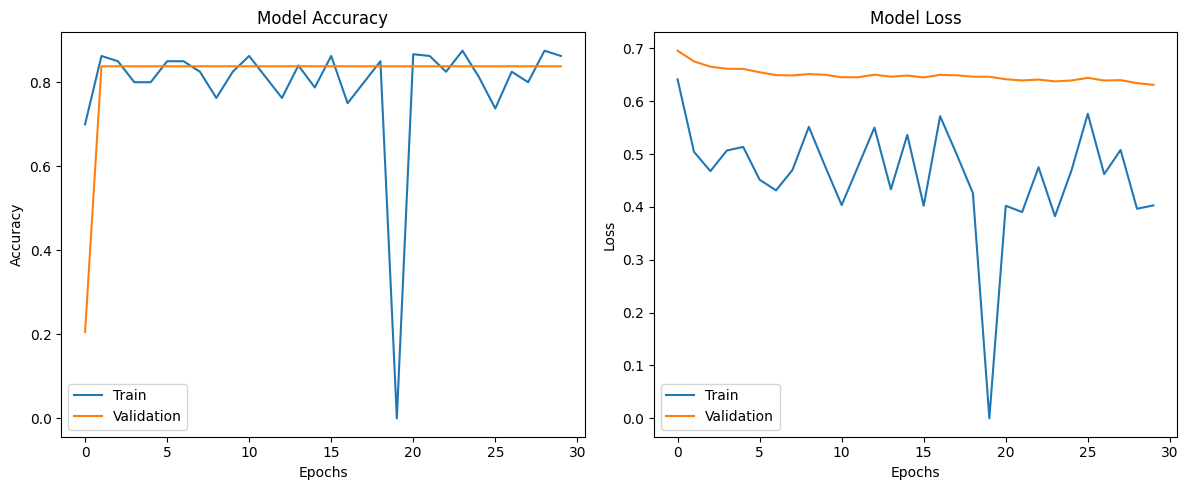

In [ ]:
import os
import matplotlib.pyplot as plt

def plot_graphs(history, batch_size):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

    # Plot accuracy
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title("Model Accuracy")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(['Train', 'Validation'])

    # Plot loss
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title("Model Loss")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Loss")
    axs[1].legend(['Train', 'Validation'])

    plt.tight_layout()  # Adjust layout to make sure plots don't overlap

    # Ensure the save directory exists
    save_dir = '/app/data/graphs/'
    os.makedirs(save_dir, exist_ok=True)

    # Create the filename using the dataset path and batch size
    dataset_name = os.path.basename(dataset_path[18:])  # filter out '/app/data/Datasets/' 
    filename = f"{dataset_name}_100epoch_batch{batch_size}_{model_name}.png"

    # Save the figure
    save_path = os.path.join(save_dir, filename)
    plt.savefig(save_path)
    print(f"Graph saved at: {save_path}")

    plt.show()

# plot
plot_graphs(history, batch)


Prediction for Model 1:


In [ ]:
# import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, average_precision_score
# import seaborn as sns
# import matplotlib.pyplot as plt

loss, accuracy = model.evaluate(test_generator, verbose=False)
# Predict on test data
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Calculate precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

# Calculate mAP
# Note: This assumes binary classification. For multi-class, you'll need to modify this.
mAP = average_precision_score(y_true, y_pred[:, 1])

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Log the metrics
with open(log_file, 'a') as f:
    f.write(f"Testing Accuracy: {accuracy:.4f}\n")
    f.write(f"Precision: {precision:.4f}\n")
    f.write(f"Recall: {recall:.4f}\n")
    f.write(f"F1 Score: {f1:.4f}\n")
    f.write(f"mAP: {mAP:.4f}\n")
    f.flush()

# Plot and save confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png')
plt.close()

# Print metrics
print(f"Testing Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"mAP: {mAP:.4f}")
print("Confusion Matrix saved as 'confusion_matrix.png'")

# Save model
model.save(f"/app/data/{model_name}_{}.keras")

In [ ]:
# loss, accuracy = model.evaluate(test_generator, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
with open(log_file, 'a') as f:
    f.write(f"Testing Accuracy:  {accuracy:.4f}\n")
    f.flush()

# save model
model.save("tf_model.keras")


Testing Accuracy:  0.8379
